In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from scipy.stats import linregress
from sklearn.metrics import r2_score

import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point, Polygon
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("RdGy")

import pandas as pd

%load_ext autoreload
%autoreload 2

## Load Natural Earth Low-res Shapefile of Canada

In [2]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

## Define projection and project shapefile into rotated pole coordinates of CanRCM4 model

In [3]:
prj4crs = {'proj': 'ob_tran', 'o_proj':'longlat', 'lon_0':-97, 'o_lat_p':42.5, 'a':1, 'to_meter':0.0174532925199, 'no_defs':True}
canada = can_geom.to_crs(prj4crs)

## Load indices masked to Canada-only (pre-calculated)

In [4]:
with open('/home/nannau/Desktop/shapeindex.pickle', 'rb') as f:
    index_shp_coord = pickle.load(f)

## Load Rainload models and apply mask
---
Load data and interpolate the design value field

In [5]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/storage/home/nannau/mask.nc'
dv = 'Rain-RL50'

interp_dict = get_interpolation(mask_path, PATH, dv)
midx = interp_dict['idx']
midx_shp = np.logical_and(np.array(index_shp_coord), midx)

iens = interp_dict['iens'][:, midx_shp].T

### Project rotated CanRCM4 grids to regular and make longitude measure from West as in Francis's mapping approach

In [6]:
lon, lat = interp_dict['irlon_ens'], interp_dict['irlat_ens']
p = Proj(prj4crs, preserve_units=True)
nlon, nlat = p(lon, lat, inverse=True)
olon, olat = p(nlon, nlat)

nlon = -nlon
nlat[midx_shp].min(), nlat[midx_shp].max(), nlon[midx_shp].min(), nlon[midx_shp].max()

(41.941108772362774, 75.65867418669218, 53.00000330344465, 140.98550658207768)

### Define the 6 piecewise functions as outlined in Francis's approach.


In [74]:
t1, t2 = np.deg2rad(nlat[midx_shp].min()), np.deg2rad(nlat[midx_shp].max())
l2, l1 = np.deg2rad(nlon[midx_shp].min()), np.deg2rad(nlon[midx_shp].max())

ot1, ot2 = np.deg2rad(olat[midx_shp].min()), np.deg2rad(olat[midx_shp].max())
ol2, ol1 = np.deg2rad(olon[midx_shp].min()), np.deg2rad(olon[midx_shp].max())

print("l1", np.rad2deg(l1), "l2", np.rad2deg(l2), np.rad2deg(t1), np.rad2deg(t2))

def loncos(l, l1, l2):
    return np.cos(2*np.pi*(l1-l)/(l1-l2))
    
def latcos(t, t1, t2):
    return np.cos(2*np.pi*(t-t1)/(t2-t1))
    
def f1(x):
    if (l2 <= x) & (x<= (l1+l2)/2.):
        return 0.
    elif ((l1+l2)/2. < x) & (x <= l1):
        return (loncos(x, l1, l2)+1)/2.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g1(x):
    if (t1 <= x) & (x <= (t1+t2)/2.):
        return (latcos(x, t1, t2)+1)/2.
    elif ((t1+t2)/2. < x) & (x <= t2):
        return 0.
    else:
        print(t1, t2, x)
        raise NameError("Did not meet stop criterion.")
        
def f2(x):
    if (l2 <= x) & (x<=l1):
        return (1-loncos(x, l1, l2))/2.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g2(x): 
    if (t1 <=  x) & (x <= t2):
        return (1-latcos(x, t1, t2))/2.
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
def f3(x):
    if (l2 <= x) & (x <= (l1+l2)/2):
        return (loncos(x, l1, l2)+1)/2.
    elif ((l1+l2)/2 < x) & (x <= l1):
        return 0.
    else:
        print(l1, l2, x)
        raise ValueError("Did not meet stop criterion.")
def g3(x):
    if (t1 <= x) & (x <= (t1+t2)/2):
        return 0.
    elif (((t1+t2)/2) < x) & (x <= t2):
        return (latcos(x, t1, t2)+1)/2 
    else:
        print(t1, t2, x)
        raise ValueError("Did not meet stop criterion.")
    
def g(m, t):
    if m == 1:
        return g1(t)
    if m == 2:
        return g2(t)
    if m == 3:
        return g3(t)
def f(n, l):
    if n == 1:
        return f1(l)
    if n == 2:
        return f2(l)
    if n == 3:
        return f3(l)
    
hmn = np.ones((3, 3))
def h(t, l):
    for n in np.arange(1, 4):
        for m in np.arange(1, 4):
            hmn[m-1, n-1] = g(m, t)*f(n, l)
    return hmn
          
X = interp_dict['iens'].mean(axis=0).copy()


l1 140.98550658207768 l2 53.00000330344465 41.941108772362774 75.65867418669218


In [75]:
xy = np.array([['a', 'b', 'c'],
             ['d', 'e', 'f'],
             ['g', 'h', 'i']])
xy.reshape((1, 9))
xy[:, 0]
# m is vertical
# n is horizontal
# so, order of array reshaped is then:
tuples = [(3,1),(2,1),(1,1),(3,2),(2,2),(1,2),(3,3),(2,3),(1,3)]
X.shape, nlat.shape, nlon.shape

((2015000,), (2015000,), (2015000,))

Define dataframe containing the $\lambda$ (longitude) and $\theta$ (latitude) and the corresponding grid cell value. 

In [76]:
lat_bdry = ((np.deg2rad(nlat) < t2) & (np.deg2rad(nlat) > t1)) 
lon_bdry = ((np.deg2rad(nlon) < l1) & (np.deg2rad(nlon) > l2))
bdryidx = np.logical_and(lat_bdry, lon_bdry)

coordf = pd.DataFrame({'iens': X, 
                       'ilat_ens': np.deg2rad(nlat), 
                       'ilon_ens': np.deg2rad(nlon)}
                     )

# coordf = coordf[((coordf['ilat_ens'] < t2)&
#                  (coordf['ilat_ens'] > t1)&
#                  (coordf['ilon_ens'] < l1)&
#                  (coordf['ilon_ens'] > l2))]

midxm = np.logical_and(midx_shp, bdryidx)

In [77]:
# Populate the entries of the 3x3 matrix for h_mn 
d = np.ones((X.shape[0], hmn.shape[0], hmn.shape[1]))
print(d.shape, X.shape)

for i, cell in enumerate(X):
    if bdryidx[i]:
        cell = np.broadcast_to(cell, (hmn.shape))
        d[i] = np.multiply(cell, h(coordf['ilat_ens'].values[i], coordf['ilon_ens'].values[i]))

# Convert back to degrees
coordf = coordf.apply(np.rad2deg, columns=['ilat_ens', 'ilon_ens'])


(2015000, 3, 3) (2015000,)


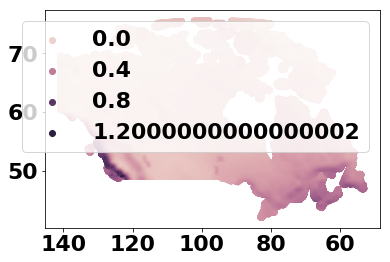

In [78]:
# sns.scatterplot(coordf.ilon_ens, coordf.ilat_ens, hue=coordf.iens, linewidth=0)
sns.scatterplot(nlon[midx_shp], nlat[midx_shp], hue=X[midx_shp], linewidth=0)
plt.gca().invert_xaxis()

In [79]:
d.shape

(2015000, 3, 3)

In [80]:
dmn = d.reshape((d.shape[0], d.shape[1]*d.shape[2]))[midxm, ...]
# reshape into features x grid cells

In [81]:
dmn

array([[0.        , 0.2186919 , 0.06385581, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21786773, 0.06424468, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21704366, 0.06463315, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.0151233 ,
        0.00694432],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01477249,
        0.00693686],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01490726,
        0.00715786]])

According to the new approach
$$\sum_m{ \sum_n} h_{m, n}(\theta, \lambda) = 1$$

Check that this is true by un-weighting the `d` matrix by the mean design value field.

In [82]:
np.allclose(dmn.sum(axis=1)/X[midxm], 1.)
dmn.sum(axis=1)

array([0.28256005, 0.28212218, 0.28168431, ..., 0.02211846, 0.02176119,
       0.02211972])

## Match and load observation station locations to their nearest interpolated CanRCM grid cell

In [83]:
df = pd.read_csv('/storage/home/nannau/Interim_snow_rain_load_LRstations_delivered_hist.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,2.0,0.763
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.7,0.571
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.4,0.795
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.8,0.371
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.4,0.565


In [84]:
dv = 'RL50 (kPa)'
ndf = match_coords(df, interp_dict, dv, midx_shp)
ndf = ndf[ndf['RL50 (kPa)'] > 0.0]
print("There are ", ndf.shape, "real station observations to fit.")
ndf.head()

There are  (367, 5) real station observations to fit.


,RL50 (kPa),lat,lon,obs_coords,matched_idx
nearest_grid,,,,,
58,0.386,42.2756,-82.9556,"(-4.286848910227873, 10.373390404111557)",58
74,0.465,42.3333,-82.9333,"(-4.227125340313413, 10.379271031382924)",74
413,0.374,42.9922,-82.3047,"(-3.4945859613826147, 10.7134921602455)",413
538,0.564,42.8667,-80.5500,"(-3.3628448895127754, 11.999925006386508)",538
558,0.440,43.0331,-81.1511,"(-3.290371679059054, 11.534368202439223)",558


## Now use the real observations and regress

In [85]:
robs_idx = ndf['matched_idx']
robs = ((ndf[dv].values))
reofs = dmn[robs_idx, :]

reofs.shape, robs.shape

((367, 9), (367,))

### Compare the observations with the mean field at their matched indices 

slope 1.0889276715640803 r2_val 0.8550285867810525


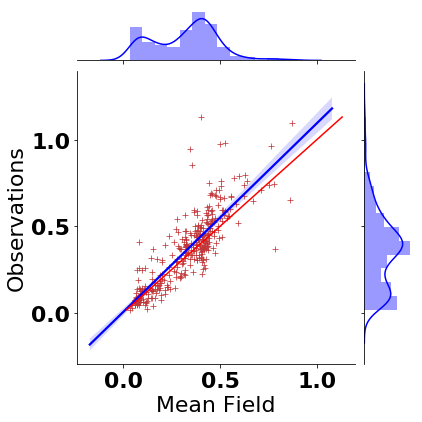

In [86]:
meanfield = iens.mean(axis=1)[robs_idx, ...]
sns.jointplot(meanfield, robs, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(meanfield, robs, marker='+')
sns.lineplot(robs.T, robs.T, color='r', dashes=True)
plt.ylabel('Observations')
plt.xlabel('Mean Field')

slope, intercept, r_value, p_value, std_err = linregress(meanfield, robs)
print("slope", slope, "r2_val", r_value)

Compare the distributions of the station observations and of the models

Fit the model and predict it

In [87]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()

df_results = pd.DataFrame({'Observations': robs, 'Reconstruction': linrpredictions, 'lat': ndf['lat']})
"Regressed model score from spatial basis patterns: {}".format(rmodel.score(reofs, robs))

'Regressed model score from spatial basis patterns: 0.6569168645439044'

List the coefficients from the regression

In [88]:
print("Model coefficients", rmodel.coef_)
print("Model intercept", rmodel.intercept_)

Model coefficients [ 1.25893424  0.7518282   0.86245044  0.90049435 -0.89783342  0.4256161
 -8.64445169 -0.57144822 -2.98344271]
Model intercept 0.14756456362138756


/home/nannau/climpyrical-venv/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


slope of best fit 0.6569168645439047
r2 score of spatial basis pattern fit 0.6569168645439044
r2_val of reconstruction score 0.8105040805226739
Std deviation ratio of vectors [models/]: 0.0738042861676272


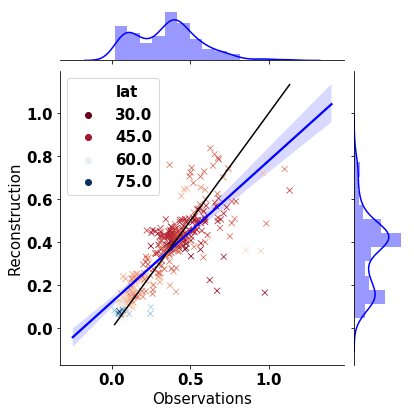

In [92]:
sns.jointplot('Observations', 'Reconstruction', color='blue',
marker='+', data=df_results,
kind="reg", scatter_kws={"s": 0.001})

sns.lineplot('Observations', 'Observations', data=df_results, color='black')
sns.scatterplot('Observations', 'Reconstruction', marker='x', hue='lat', palette='RdBu', data=df_results)
slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope of best fit", slope)
print("r2 score of spatial basis pattern fit", rmodel.score(reofs, robs))
print("r2_val of reconstruction score", r_value)
print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

## Now reconstruct the spatial field

## Add noise to the ideal pseudo observations, regress, and reconstruct and compare each step with anomaly

[(2, 0), (2, 1), (2, 2), (1, 0), (1, 1), (1, 2), (0, 0), (0, 1), (0, 2)]


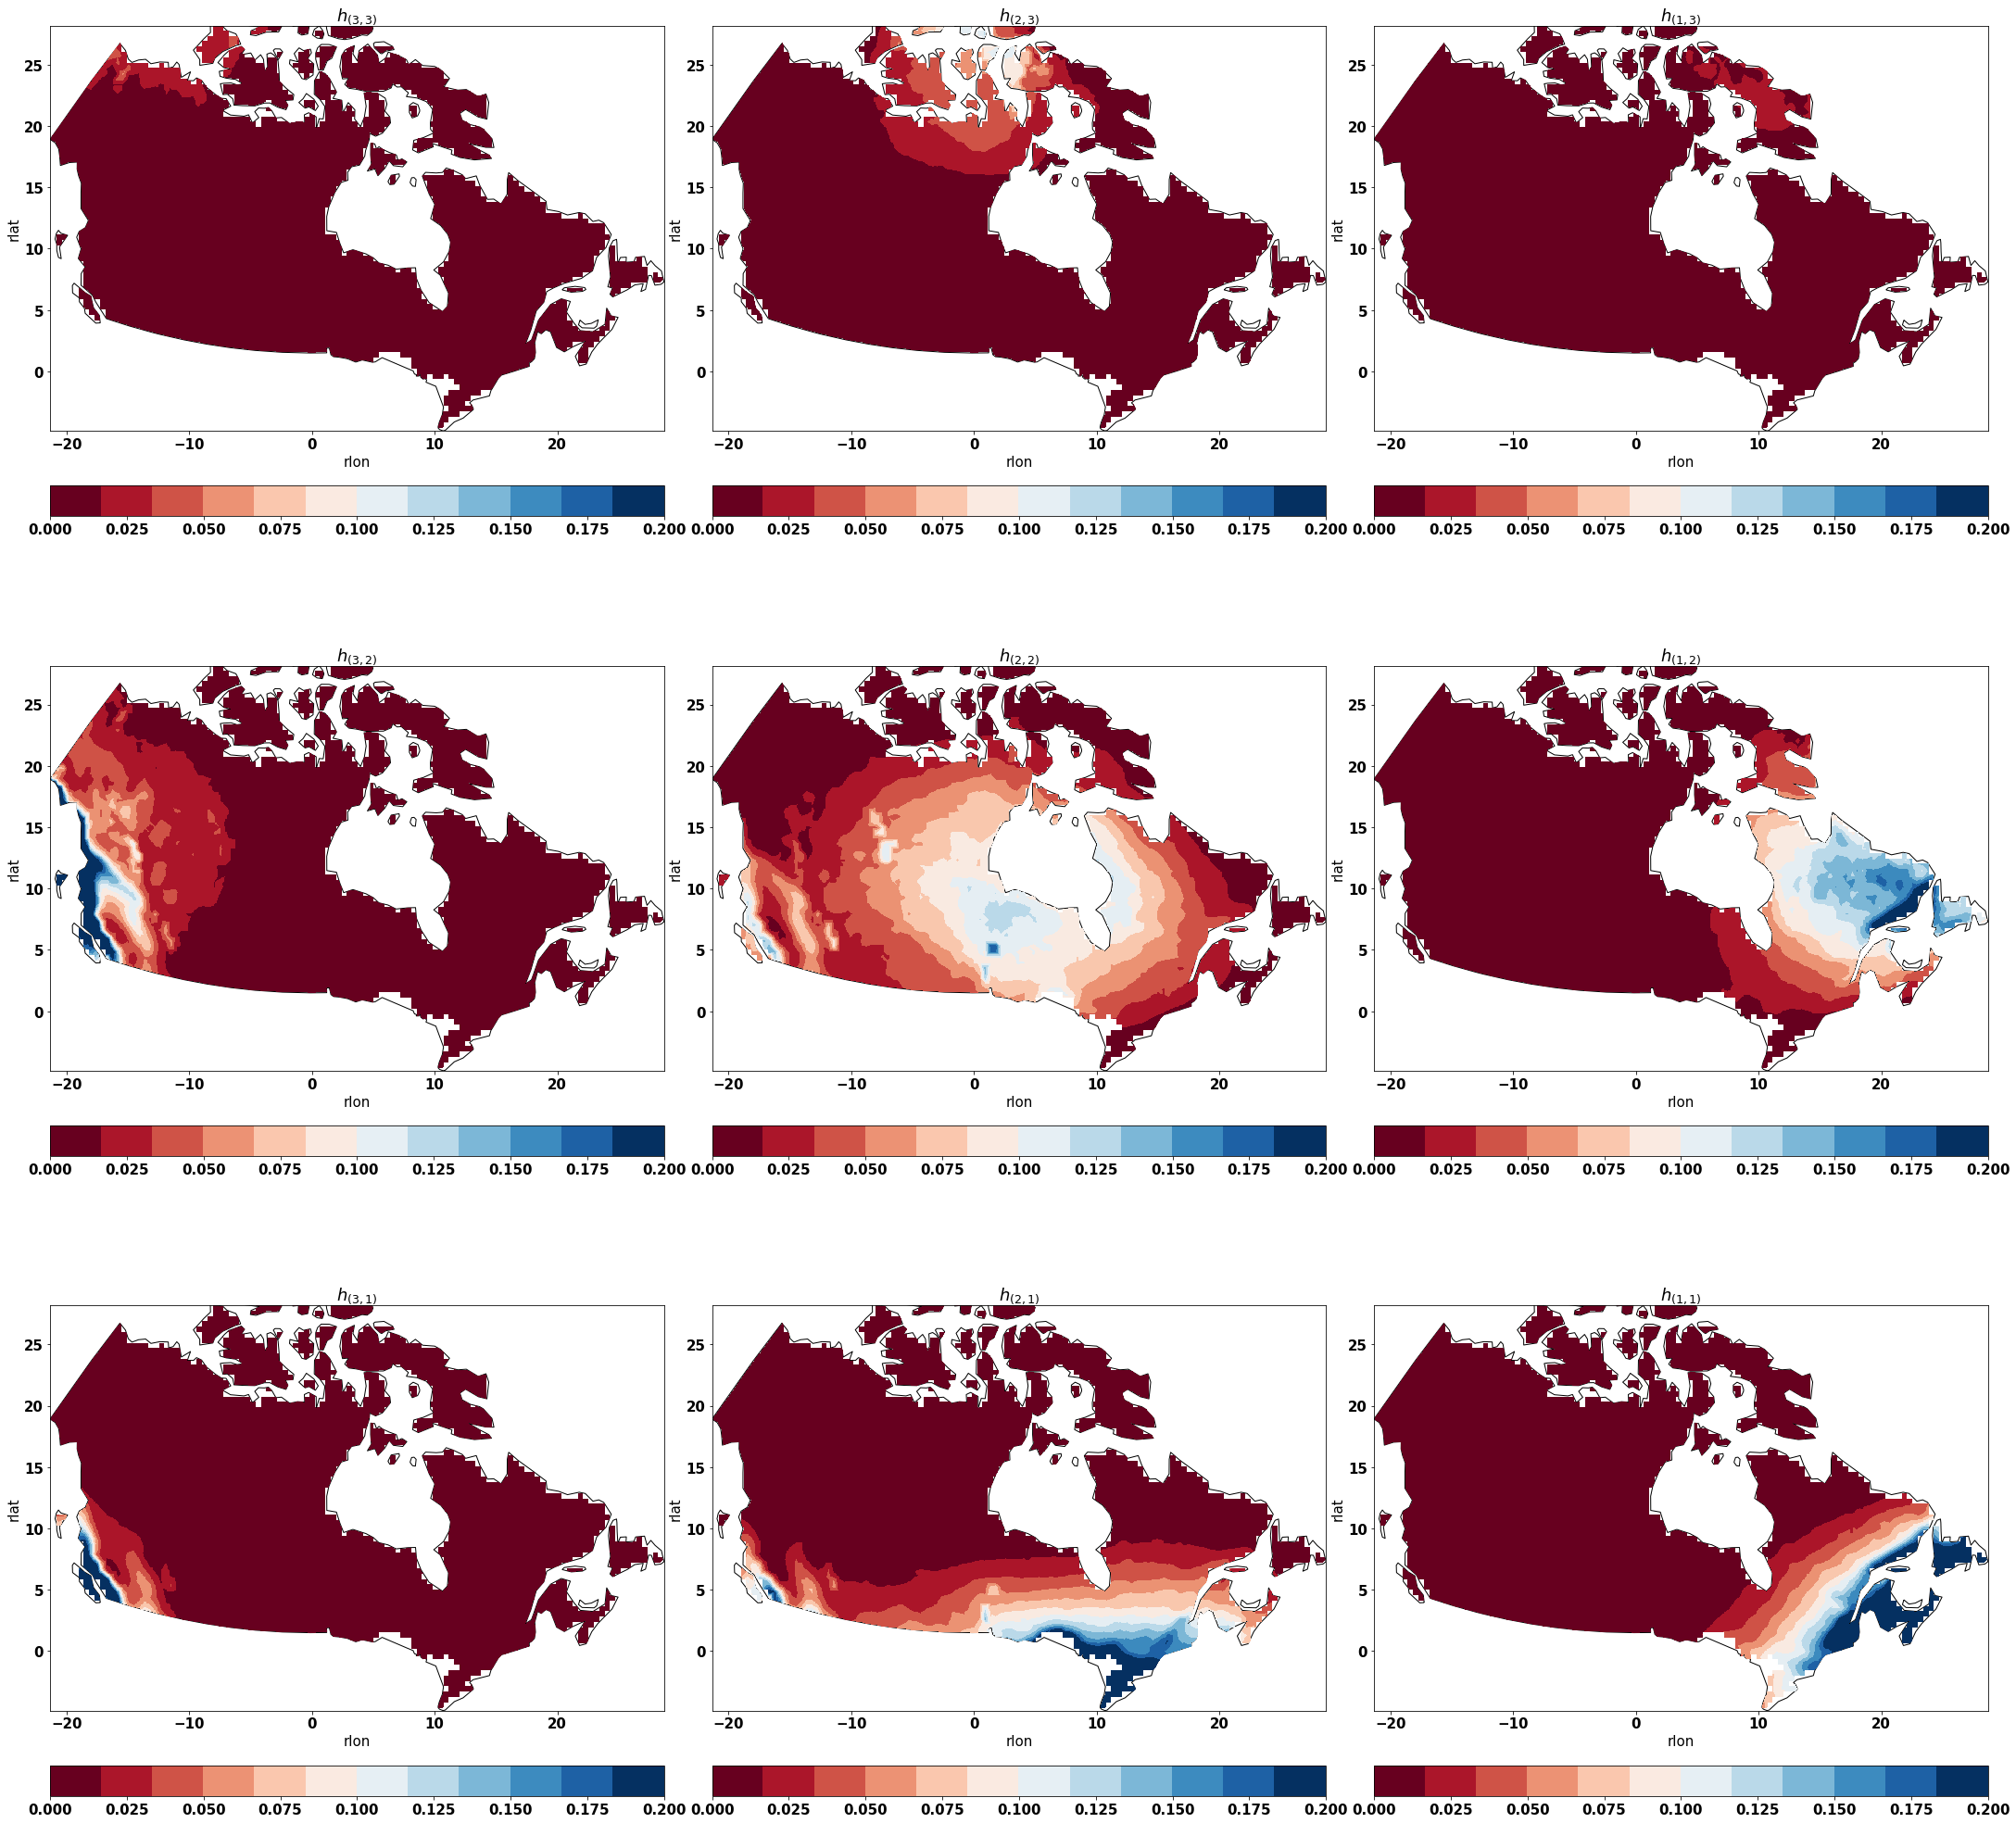

In [93]:
# del iens_copy, X, predictions, y, X_v
iens_copy = np.full_like(np.zeros(interp_dict['iens'].shape), np.nan)
X_v = interp_dict['iens']
X_v[:, ~midx_shp] = np.nan 
vmin, vmax = 0.0, 0.2

fig, ax = plt.subplots(3, 3, figsize=(30,30))

tu = [tuple(x) for x in (np.array(tuples) - 1)]
tu.reverse()
tu = [(x[1], x[0]) for x in tu]
print(tu)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

for i, t in enumerate(tu):
    dv_recon = interp_dict['iens'][0, :].copy()
    dv_recon[midxm] = dmn[:, i]#rmodel.predict(vT[:n, :].T)
    dv_recon[~midxm] = np.nan

    X = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])
    x1, x2, y1, y2 = interp_dict['irlon_ens'].min(), interp_dict['irlon_ens'].max(), interp_dict['irlat_ens'].min(), interp_dict['irlat_ens'].max()
    X_v = np.reshape(X_v, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))
    xc, yc = interp_dict['irlon'], interp_dict['irlat']
    ax[t].set_title('$h_{%s}$' % (tuples[i],))
    ax[t].set_xlabel('rlon')
    ax[t].set_ylabel('rlat')
    ax[t].set_ylim(canada.bounds.miny.values[0], y2)
    ax[t].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    canada.plot(ax=ax[t], color='white', edgecolor='black', zorder=1)

    img = ax[t].imshow(X, origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern',vmin=vmin, vmax=vmax, zorder=2,extent=[x1, x2, y1, y2])
    plt.colorbar(img, orientation='horizontal', ax=ax[t], fraction=0.046, pad=0.08)

#     ax[i, 1].set_title('Ensemble Mean')
#     ax[i, 1].set_xlabel('rlon')
#     ax[i, 1].set_ylabel('rlat')
#     ax[i, 1].set_ylim(canada.bounds.miny.values[0], y2)
#     ax[i, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
    
#     canada.plot(ax=ax[i, 1], color='white', edgecolor='black', zorder=1)

#     img = ax[i, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern', zorder=2, extent=[x1, x2, y1, y2])
#     plt.colorbar(img, orientation='horizontal', ax=ax[i, 1], fraction=0.046, pad=0.08)

    
# dv_recon[midxm] = rmodel.predict(dmn)
# dv_recon[~midxm] = np.nan

# pred = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

    
# ax[9, 0].set_xlabel('rlon')
# ax[9, 0].set_ylabel('rlat')
# ax[9, 0].set_ylim(canada.bounds.miny.values[0], y2)
# ax[9, 0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
# canada.plot(ax=ax[9, 0], color='white', edgecolor='black', zorder=1)

# img = ax[9, 0].imshow(pred, origin='lower', vmin=vmin, vmax=vmax, cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern', zorder=2,extent=[x1, x2, y1, y2])
# plt.colorbar(img, orientation='horizontal', ax=ax[9, 0], fraction=0.046, pad=0.08)

# ax[9, 1].set_title('Ensemble Mean')
# ax[9, 1].set_xlabel('rlon')
# ax[9, 1].set_ylabel('rlat')
# ax[9, 1].set_ylim(canada.bounds.miny.values[0], y2)
# ax[9, 1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])

# canada.plot(ax=ax[9, 1], color='white', edgecolor='black', zorder=1)

# img = ax[9, 1].imshow(X_v.mean(axis=0), origin='lower', vmin=vmin, vmax=vmax, cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern', zorder=2, extent=[x1, x2, y1, y2])
# plt.colorbar(img, orientation='horizontal', ax=ax[9, 1], fraction=0.046, pad=0.08)

    
plt.tight_layout(pad=0.6, h_pad=.2, w_pad=0.1)
plt.savefig('recon_mean_comparison_spatial')

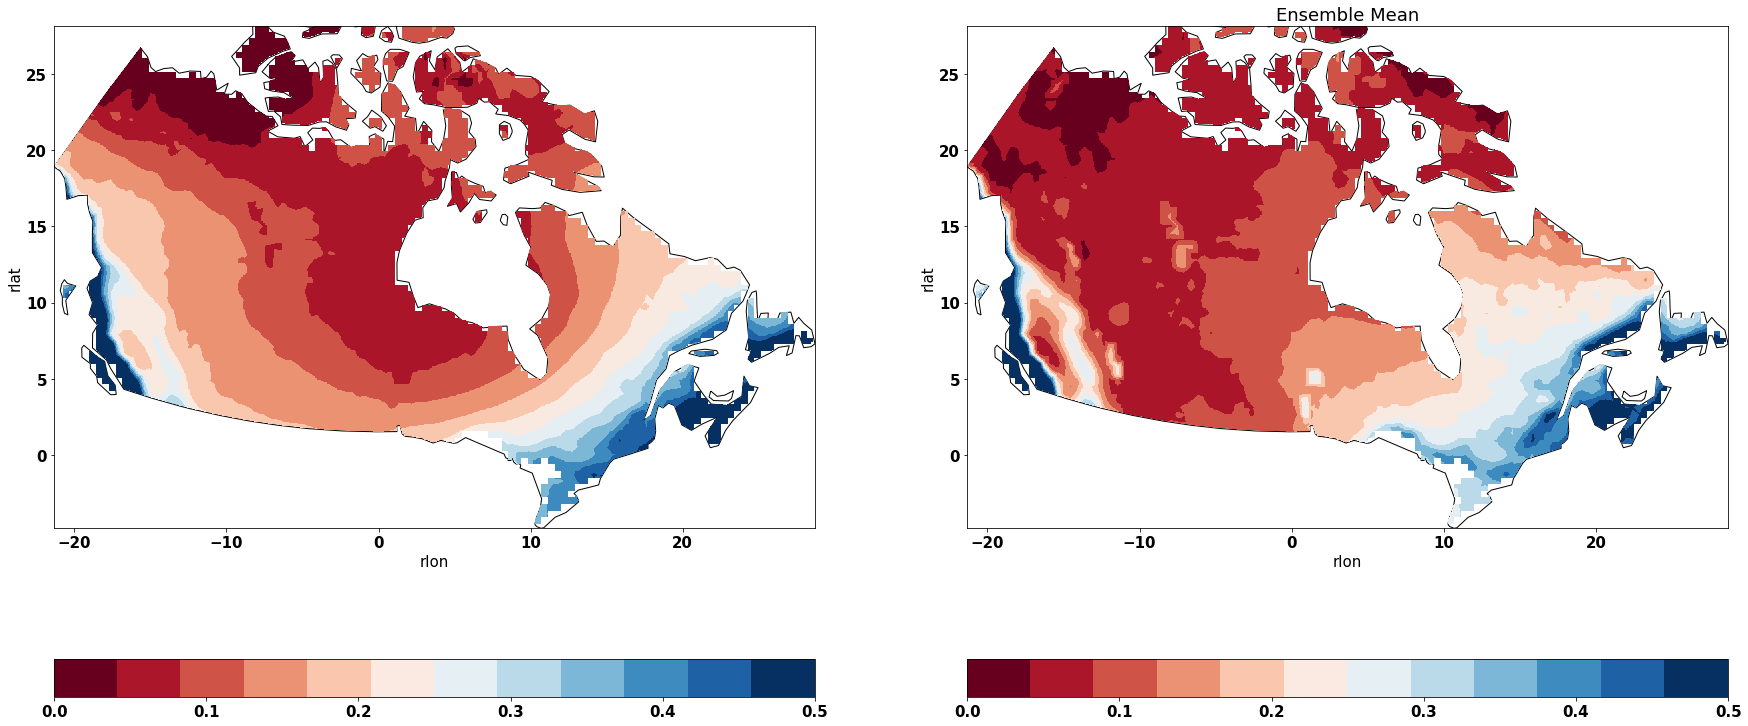

In [98]:
dv_recon[midxm] = rmodel.predict(dmn)
dv_recon[~midxm] = np.nan

vmin = 0
vmax = .5

pred = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

fig, ax = plt.subplots(1, 2, figsize=(30,30))
    
ax[0].set_xlabel('rlon')
ax[0].set_ylabel('rlat')
ax[0].set_ylim(canada.bounds.miny.values[0], y2)
ax[0].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])
canada.plot(ax=ax[0], color='white', edgecolor='black', zorder=1)

img = ax[0].imshow(pred, origin='lower', vmin=vmin, vmax=vmax, cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern', zorder=2,extent=[x1, x2, y1, y2])
plt.colorbar(img, orientation='horizontal', ax=ax[0], fraction=0.046, pad=0.08)
ax[1].set_title('Ensemble Mean')
ax[1].set_xlabel('rlon')
ax[1].set_ylabel('rlat')
ax[1].set_ylim(canada.bounds.miny.values[0], y2)
ax[1].set_xlim(canada.bounds.minx.values[0], canada.bounds.maxx.values[0])

canada.plot(ax=ax[1], color='white', edgecolor='black', zorder=1)

img = ax[1].imshow(X_v.mean(axis=0), origin='lower', vmin=vmin, vmax=vmax, cmap=plt.cm.get_cmap('RdBu', 12), label='spatial basis pattern', zorder=2, extent=[x1, x2, y1, y2])
plt.colorbar(img, orientation='horizontal', ax=ax[1], fraction=0.046, pad=0.08)
